Epoch 1/300
192/192 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 2/300
192/192 [==============================] - 0s 853us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/300
192/192 [==============================] - 0s 853us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/300
192/192 [==============================] - 0s 953us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/300
192/192 [==============================] - 0s 875us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/300
192/192 [==============================] - 0s 832us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/300
192/192 [==============================] - 0s 827us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/300
192/192 [==============================] - 0s 838us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/300
192/192 [==============================] - 0s 832us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/300
192/192 [==============================] - 0s 827us/step - los

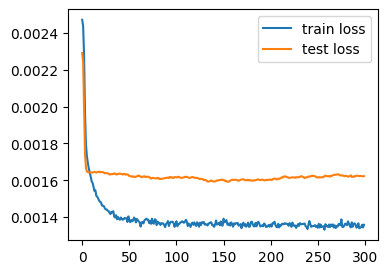

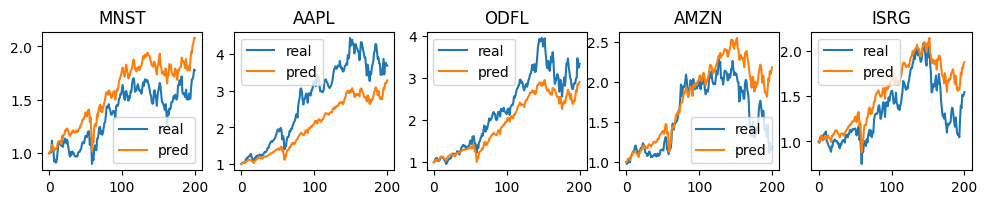

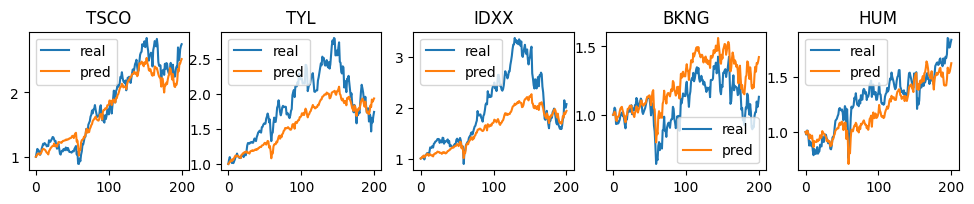

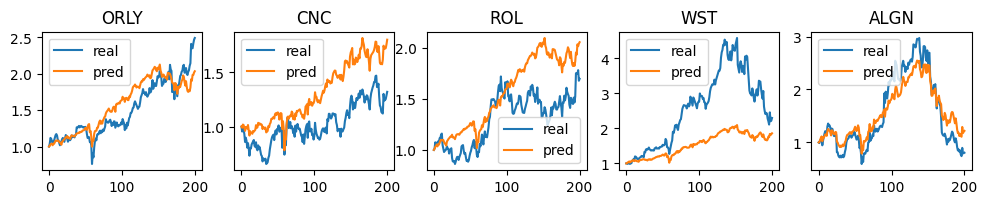

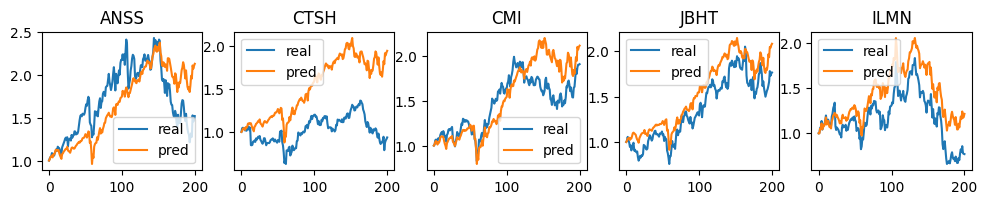

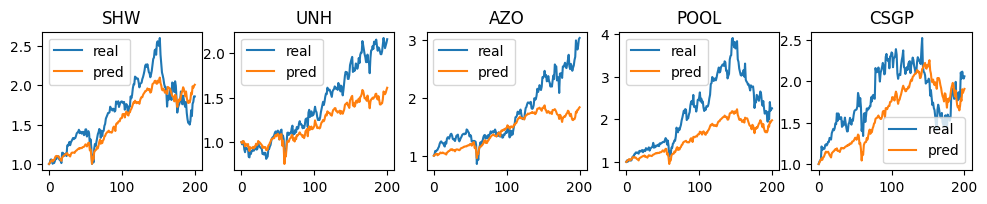

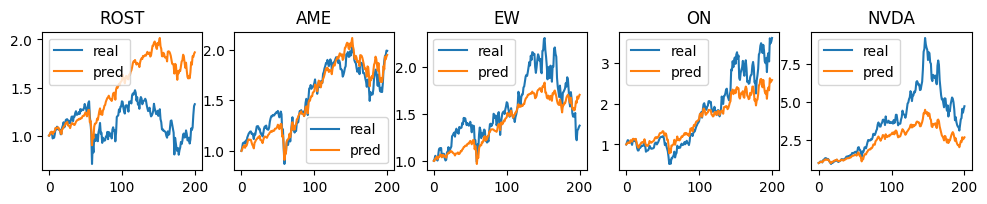

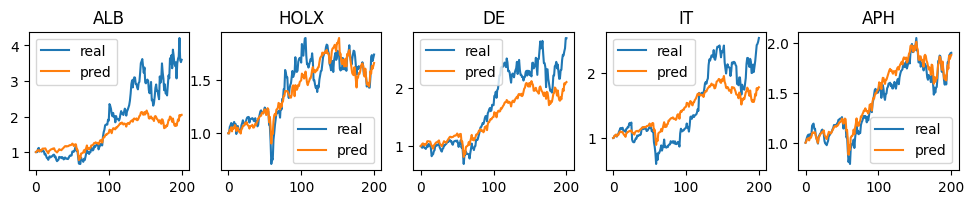

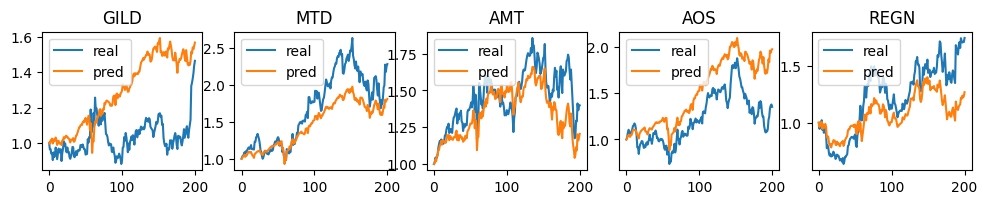

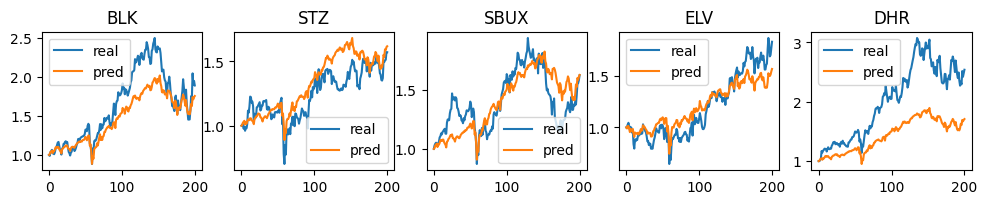

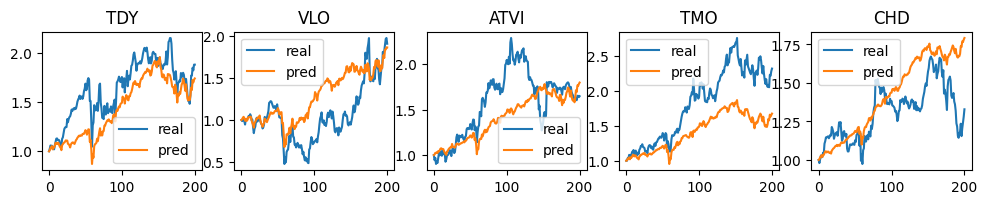

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.layers import Flatten, Dot, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pickle

N_FACTORS = 10    # number of factors

# 주간 수익률 데이터를 읽어온다.
rtn_df = pd.read_csv('top50-W-Stock_LogReturn.csv', index_col=0)
rtn_R = np.array(rtn_df)

N_ROW = rtn_R.shape[0]    # time 개수
N_COL = rtn_R.shape[1]    # item (종목) 개수

# mean centering
E = rtn_R.mean(axis=0).reshape(1, N_COL)
cent_R = rtn_R - E

# unpivoting
R = pd.DataFrame(cent_R).stack().reset_index()
R.columns = ['row', 'col', 'rtn']

# 데이터 세트를 생성한다.
x_row = np.array(R['row']).astype('int').reshape(-1, 1)
x_col = np.array(R['col']).astype('int').reshape(-1, 1)
y_rtn = np.array(R['rtn']).reshape(-1, 1)

# 학습 데이터와 시험 데이터를 생성한다.
x_train_row, x_test_row, x_train_col, x_test_col, y_train, y_test = \
                    train_test_split(x_row, x_col, y_rtn, test_size = 0.1)

# 행렬분해 네트워크
x_input_row = Input(batch_shape = (None, x_row.shape[1]))
x_input_col = Input(batch_shape = (None, x_col.shape[1]))

# F-네트워크
x_row_emb = Embedding(N_ROW, N_FACTORS, name='F')(x_input_row)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Flatten()(x_row_emb)

# B-네트워크
x_col_emb = Embedding(N_COL, N_FACTORS, name='B')(x_input_col)
x_col_emb = Dropout(0.2)(x_col_emb)
x_col_emb = Flatten()(x_col_emb)

# 추정 수익률 계산
y_output = Dot(axes=1)([x_row_emb, x_col_emb])
model = Model([x_input_row, x_input_col], y_output)
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.0005))

# 학습
hist = model.fit([x_train_row, x_train_col], y_train, 
                  validation_data = ([x_test_row, x_test_col], y_test),
                  batch_size = 256, epochs = 300)

# loss history
plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# 행렬 F, B
F = model.get_layer('F').get_weights()[0]
B = model.get_layer('B').get_weights()[0]

# F, B로 추정한 주가와 실제 주가 차트를 비교한다.
sym2idx = {k:v for v, k in enumerate(list(rtn_df.columns))}
idx2sym = {v:k for k, v in sym2idx.items()}

rtn_EFB = E + np.dot(F, B.T)  # 추정된 수익률
def calc_price(r):
    prc = [1.0]
    for i in r:
        prc.append(prc[-1] * np.exp(i))
    return prc

# 10행 5열의 plot chart를 그린다.
n_from = -200   # 최근 200 weeks (약 4년)의 주가 차트
for i in np.arange(0, N_COL, 5):
    fig = plt.figure(figsize=(12, 1.8))
    for j in np.arange(i, i+5):
        # 추정 주가와 실제 주가를 계산한다.
        pred_price = calc_price(rtn_EFB[:, j][n_from:])
        real_price = calc_price(rtn_R[:, j][n_from:])
        ax = fig.add_subplot(1, 5, j % 5 + 1)
        ax.plot(real_price, label='real')
        ax.plot(pred_price, label='pred')
        ax.legend()
        ax.set_title(idx2sym[j])
    plt.show() 

In [51]:
B

array([[ 1.62075788e-01,  1.50055021e-01, -7.73092657e-02,
         9.45362449e-02, -1.01175405e-01,  7.73891434e-02,
        -6.98700622e-02, -9.41805094e-02, -2.13212818e-01,
         1.34892091e-01],
       [ 4.36355062e-02,  5.48027381e-02,  3.18340547e-02,
        -5.70228212e-02, -6.17346913e-02, -9.96913575e-03,
         8.50690156e-02,  5.56639694e-02, -9.15233791e-02,
         1.00671370e-02],
       [-5.72779961e-02,  5.52271642e-02,  8.29813555e-02,
        -1.06564701e-01, -6.15523160e-02, -2.10537370e-02,
         2.40792409e-02,  2.87862085e-02, -3.37541588e-02,
         1.21663667e-01],
       [ 4.06195112e-02,  1.10991977e-01, -2.55365446e-02,
         1.72321238e-02, -4.90294173e-02, -7.56801898e-03,
         9.52289328e-02,  1.48331702e-01, -7.47986510e-02,
         4.99872118e-02],
       [ 9.85409766e-02,  1.32242039e-01,  7.57446736e-02,
        -8.12791940e-03, -1.14128433e-01,  8.85320902e-02,
        -7.49214133e-03,  1.78109519e-02, -9.55772325e-02,
         9.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


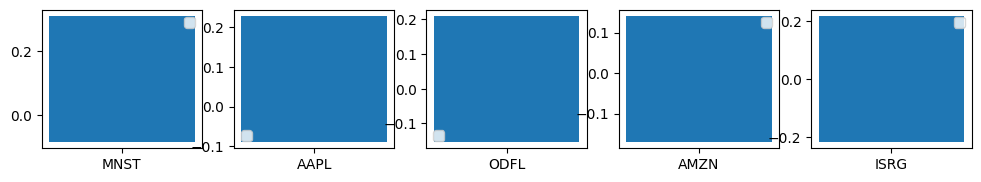

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


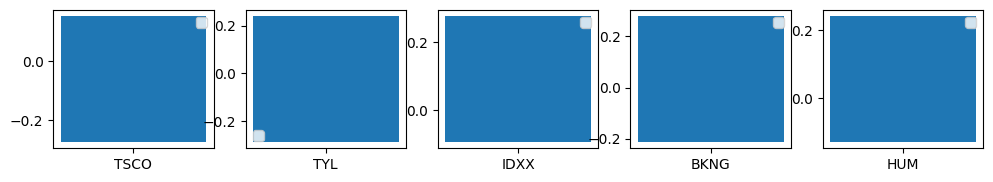

KeyError: 10

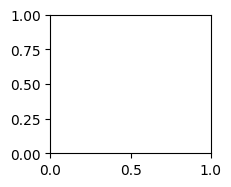

In [52]:
Beta = pd.DataFrame(B)

for i in np.arange(0, N_COL, 5):
    fig = plt.figure(figsize=(12, 1.8))
    for j in np.arange(i, i+5):
        ax = fig.add_subplot(1, 5, j % 5 + 1)
        ax.bar(idx2sym[j], Beta[j])
        ax.legend()
    plt.show() 